<a href="https://colab.research.google.com/github/asalunai/probesp-trabfinal/blob/master/lista_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilidade e Estatistica para Aprendizado de Máquina - 2020/1

# Lista 5

Aluna: Ana Luísa Cruz

GitHub: https://github.com/asalunai/probesp-trabfinal.git
---

In [1]:
# Apenas se executado no Google Colaboratory
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Instala a versão mais recentes das bibliotecas utilizadas
!pip install seaborn==0.11.
!pip install scipy==1.5.2

In [3]:
# caminhos dos arquivos de dados
csv_casos = '/content/drive/My Drive/COS868 - Probabilidade e Estatística para Aprendizado de Máquina/TrabFinal/casos-novos-ppt.csv'
csv_obito = '/content/drive/My Drive/COS868 - Probabilidade e Estatística para Aprendizado de Máquina/TrabFinal/bitos-novos-ppt.csv'

In [4]:
import pandas as pd
import numpy as np

from scipy.stats import expon, norm, weibull_min, lognorm, ks_1samp

from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', 
        style='ticks', 
        palette='Set2', 
        font='serif', 
        font_scale=1.5, 
        color_codes=True, 
        rc={'figure.figsize':(14,6)})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Estatísticas preliminares

Abaixo, estão as séries temporais para cada uma das V.A.s.

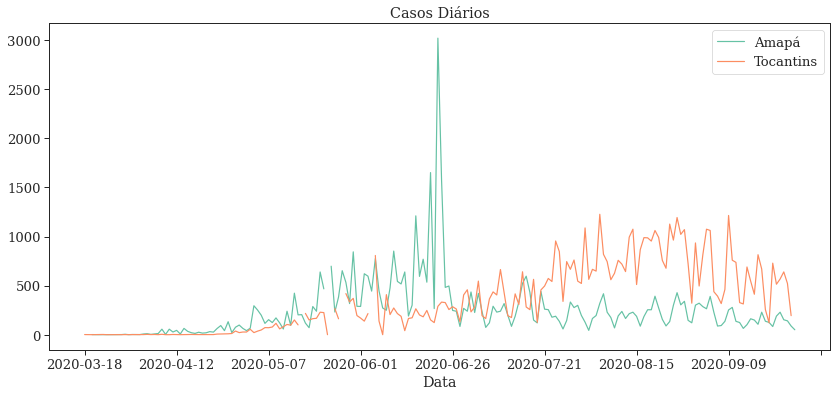

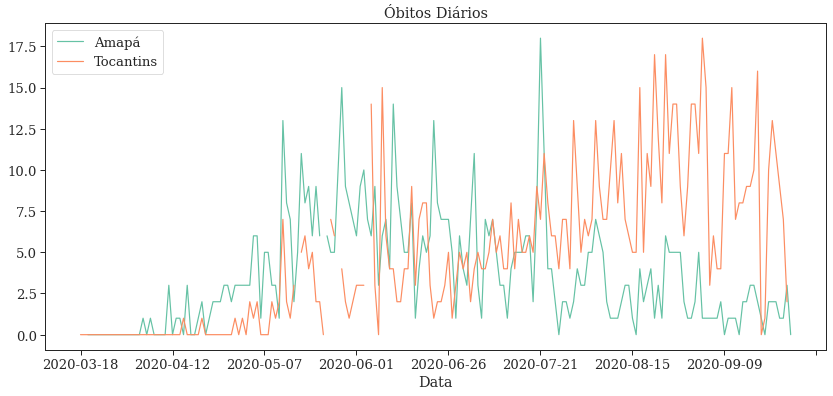

In [5]:
# Ler os dados como Pandas Dataframes:
df_casos = pd.read_csv(csv_casos, sep=';', index_col=0) #, infer_datetime_format=True)
df_obito = pd.read_csv(csv_obito, sep=';', index_col=0) #, infer_datetime_format=True)

# Plota as séries temporais
df_casos.plot(title='Casos Diários')
df_obito.plot(title='Óbitos Diários')

Abaixo estão os histogramas, boxplots, assim como as médias e os desvios-padrão.

Nota: os dados zerados foram filtrados e os outliers foram mantidos.

In [6]:
def plt_hb(df, titulo):
  estados = ['Amapá', 'Tocantins']
  df[df == 0.] = np.nan
  df = df.dropna()
  fig, sub = plt.subplots(1, 3)
  plt.subplots_adjust(wspace=0.4, hspace=0.4)
  for est, ax in zip(estados, sub.flatten()):
    sns.histplot(data=df, x=est, bins='sturges', stat="count", element="step", ax=ax)
    media, desvp = [df[est].mean(), df[est].std()]
    ax.annotate('Média = '+str("{:.2f}".format(media)), xy=(0.10, 0.95), xycoords='axes fraction')
    ax.annotate('DesvP = '+str("{:.2f}".format(desvp)), xy=(0.10, 0.90), xycoords='axes fraction')
  sub[2] = sns.boxplot(data=df)
  fig.suptitle('Histograma e Boxplot - ' + titulo)
  plt.show()

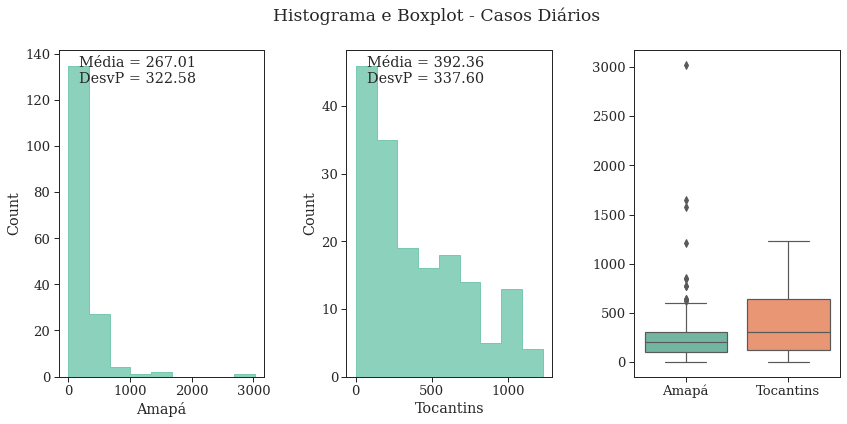

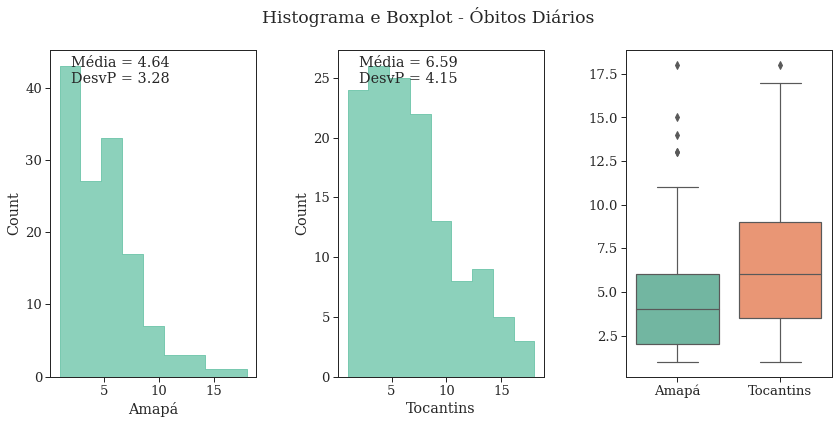

In [7]:
plt_hb(df_casos, 'Casos Diários')
plt_hb(df_obito, 'Óbitos Diários')

## 2. MLE

Para o MLE, foi utilizado a bibliotaca Scipy. Entretanto, para as distribuições de Weibull e Lognormal, foi necessário utilizar o método `_fitstart` para definir os parametros iniciais de `loc` e `scale`. 

Além disso, para Lognormal, foi necessário fixar o valor de `loc` em 0.1 (`floc=0.1`). Sem isso, o valor estava dando sempre negativo e o método `.rvs` (para gerar amostras aleatórias) dava erro.

Nota: os dados zerados foram filtrados e os outliers foram mantidos.

In [8]:
# Estimativa de parametros para as distribuições 
# de Weibull e Lognormal:
# link:
def _fitstart(data): 
  """Reference: Cohen & Whittle, (1988) "Parameter Estimation in Reliability
  and Life Span Models", p. 25 ff, Marcel Dekker
  """
  loc = data.min() - 0.01  #*np.std(data)  # alternatively subtract 0.01*stdev
  chat = 1. / (6 ** (1 / 2) / np.pi * np.std(np.log(data - loc)))
  scale = np.mean((data - loc) ** chat) ** (1. / chat)
  return chat, loc, scale

In [9]:
def plota(df, dist, ndist, param, ax, x_vars, pval, tipo):

  if tipo=='cdf':
    #print(x_vars)
    sns.histplot(data=df, bins='sturges', cumulative=True, stat="density", element="step", fill=False, ax=ax)
    sns.histplot(data=x_vars, bins=1000, cumulative=True, stat="density", element="step", fill=False, ax=ax)
    ax.set_title(ndist)
    color = ['red' if pval < 0.05 else 'blue'][0]
    ax.annotate('P = '+str("{:.2f}".format(pval)), xy=(0.10, 0.90), xycoords='axes fraction', color=color)
    ax.annotate('Loc = '+str("{:.2f}".format(param[-2])), xy=(0.10, 0.80), xycoords='axes fraction')
    ax.annotate('Scale = '+str("{:.2f}".format(param[-1])), xy=(0.10, 0.70), xycoords='axes fraction')
    ax.set_xlim(-1., df.max())

  elif tipo=='qqplot':
    qqplot(df, dist=dist, fit=True, line="45", ax=ax) #,  loc=param[-2], scale=param[-1], fit=False, distargs=param[0])
    ax.set_title(ndist)
    color = ['red' if pval < 0.05 else 'blue'][0]
    ax.annotate('P = '+str("{:.2f}".format(pval)), xy=(0.10, 0.90), xycoords='axes fraction', color=color)

  return ax


In [10]:
def final(df, titulo, tipo):

  df[df == 0.] = np.nan
  df = df.dropna()
  
  fig, sub = plt.subplots(2, 2, figsize=(14,12))
  plt.subplots_adjust(wspace=0.4, hspace=0.4)

  distribuicoes = ['expon', 'norm', 'weibull_min', 'lognorm']
  dist_nomes = ['Exponencial', 'Normal', 'Weibull', 'Lognormal']

  for dist, ndist, ax in zip(distribuicoes, dist_nomes, sub.flatten()):

    if dist == 'expon':
      param = (expon.fit(df, loc=0, optimizer ="MLE"))
      x_vars = expon.rvs(param[-2], param[-1], size=1000)
      D, pval = ks_1samp(df, expon.cdf, args=param)
      plota(df, dist, ndist, param, ax, x_vars, pval, tipo)
      
    if dist == 'norm':
      param = (norm.fit(df, loc=0, optimizer ="MLE"))
      x_vars = norm.rvs(param[-2], param[-1], size=1000)
      D, pval = ks_1samp(df, norm.cdf, args=param)
      plota(df, dist, ndist, param, ax, x_vars, pval, tipo)

    if dist == 'weibull_min':
      chat, loc, scale =_fitstart(df.values)
      #loc, scale = [0,1]
      param = (weibull_min.fit(df, chat, loc=loc, scale=scale))
      x_vars = weibull_min.rvs(param[-2], param[-1], 1000)
      x_vars = x_vars[np.isfinite(x_vars)]
      D, pval = ks_1samp(df, weibull_min.cdf, args=param)
      plota(df, dist, ndist, param, ax, x_vars, pval, tipo)
      
    elif dist == 'lognorm':
      chat, loc, scale =_fitstart(df.values)
      loc, scale = [0.1,1]
      param = (lognorm.fit(df, chat, floc=loc, scale=scale))
      x_vars = lognorm.rvs(param[-3], param[-2], param[-1], 1000)
      D, pval = ks_1samp(df, lognorm.cdf, args=param)
      plota(df, dist, ndist, param, ax, x_vars, pval, tipo)

  fig.suptitle(titulo)
  plt.show()


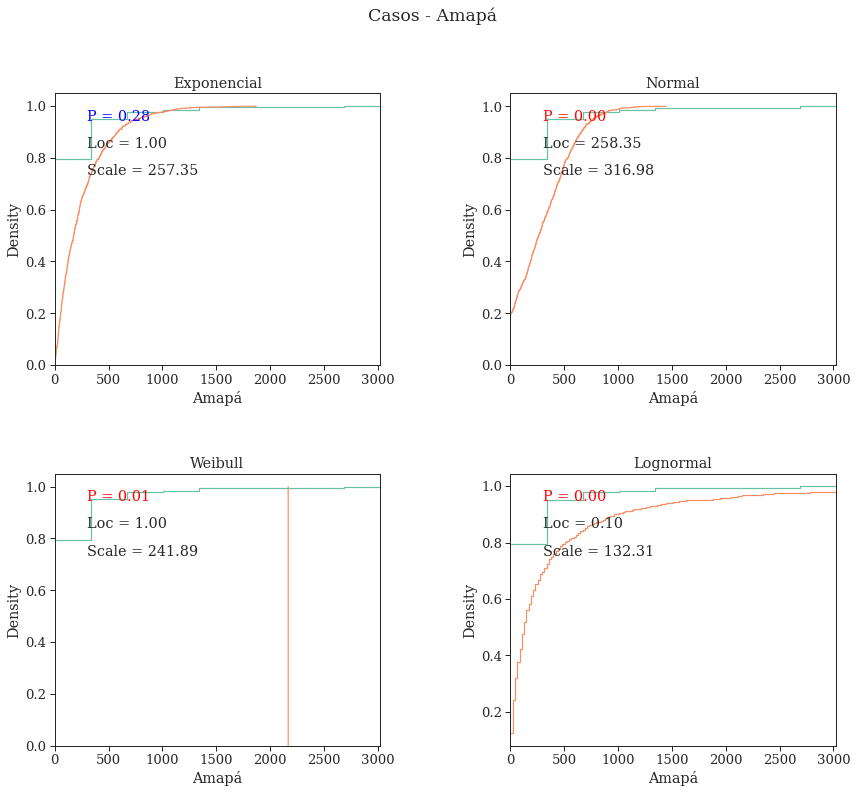

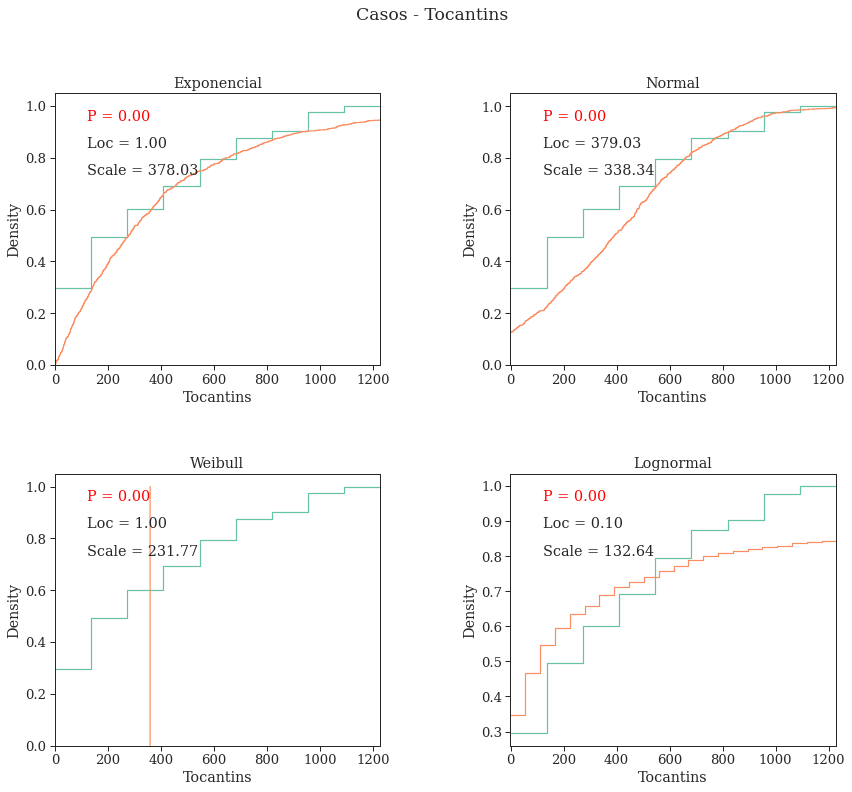

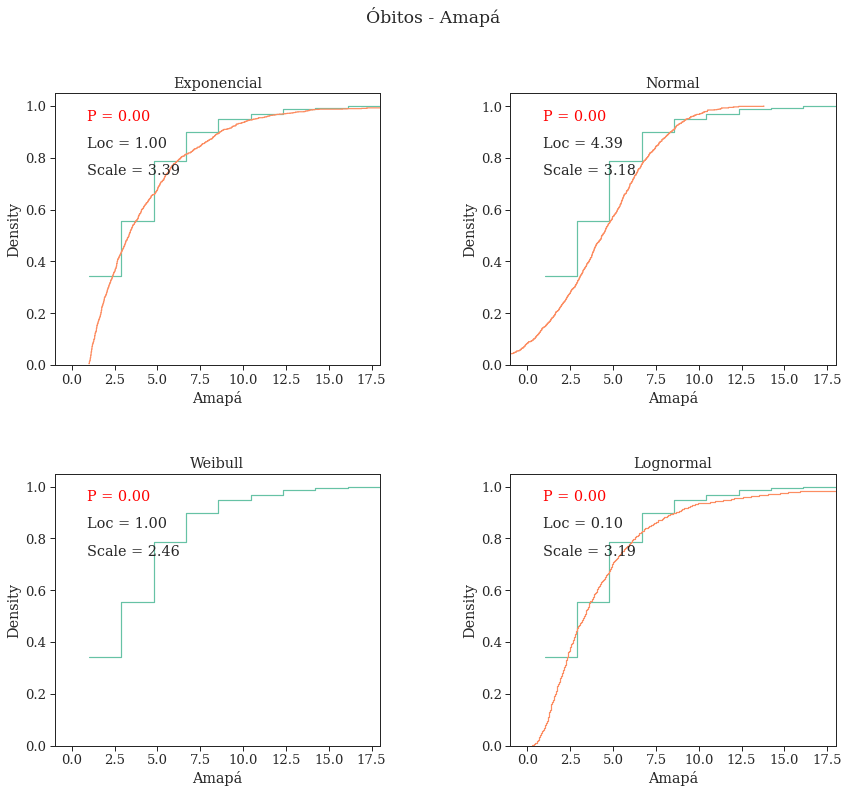

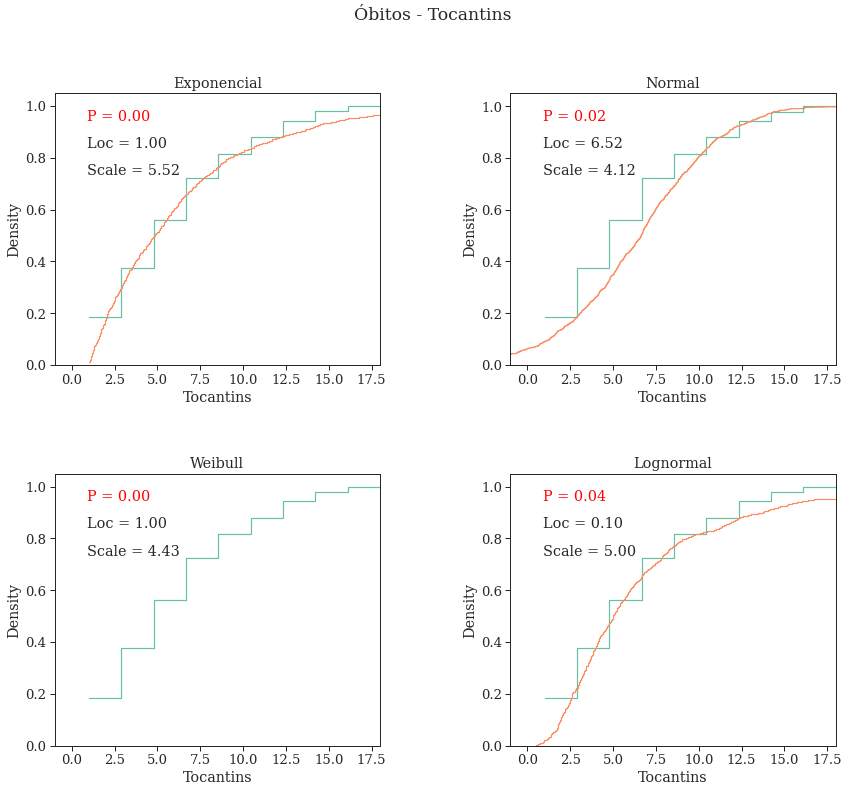

In [11]:
a = final(df_casos['Amapá'], 'Casos - Amapá', 'cdf')
a = final(df_casos['Tocantins'], 'Casos - Tocantins', 'cdf')
a = final(df_obito['Amapá'], 'Óbitos - Amapá', 'cdf')
a = final(df_obito['Tocantins'], 'Óbitos - Tocantins', 'cdf')

## 3. e 4. Probability plot e Komolgorov-Smirnov test

Foram utilizados os testes de *goodnes of fit* Chi-Square para a distribuição Geométrica e Kolmogorov-Smirnov para as distribuições normal e exponencial.

Nos gráficos abaixo, os valores de p dos testes estão nos respectivos gráficos. Valores em vermelho (azul) indicam que a Hipótese nula foi rejeitada (aceita).

É possivel ver que a Hipótese nula foi rejeitada para todas as V.A.s. e que, portanto, provavelmente nenhuma V.A. apresenta distribuição geométrica, normal ou exponencial.

Nota: Nota: os dados zerados foram filtrados e os outliers foram mantidos.

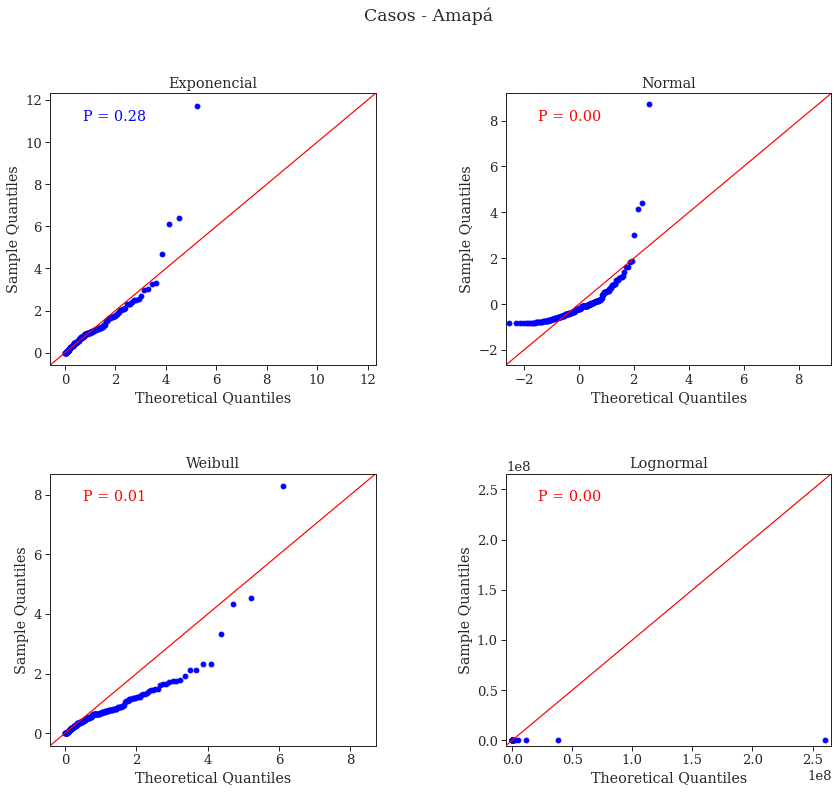

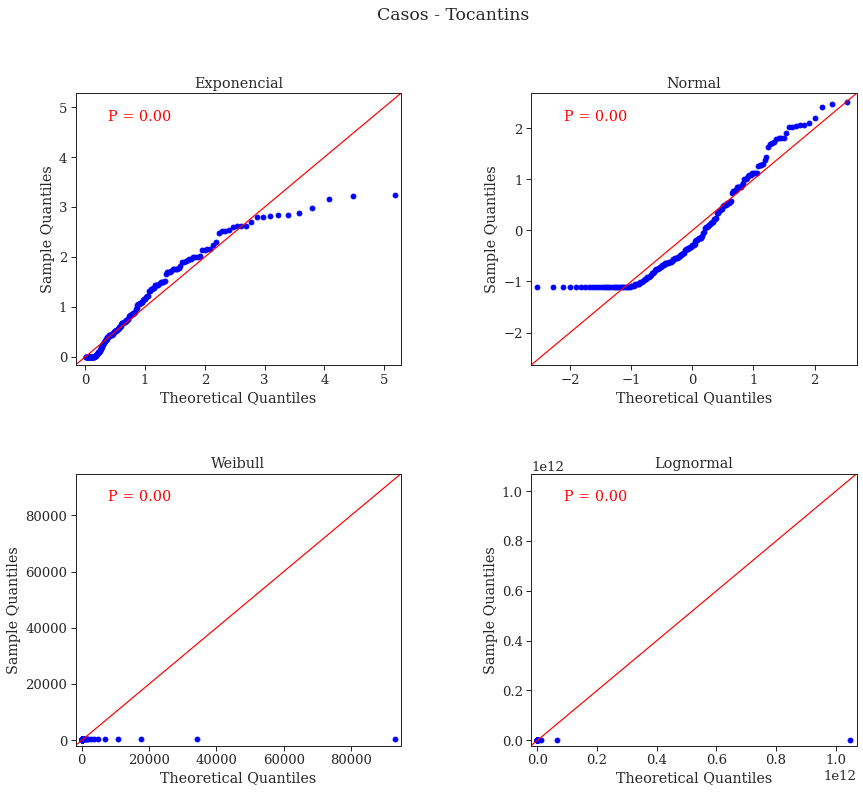

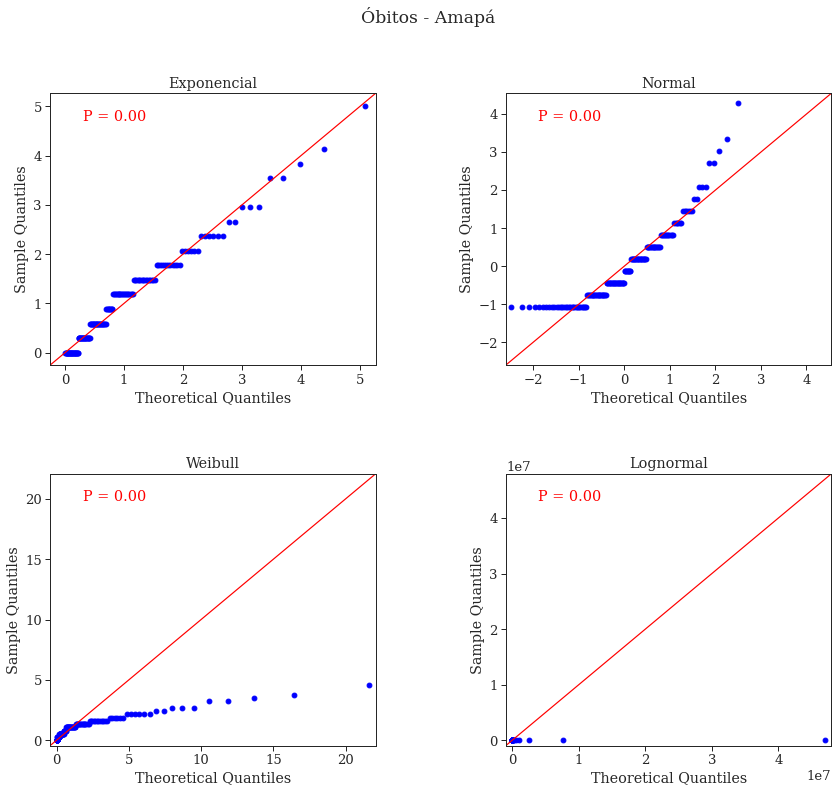

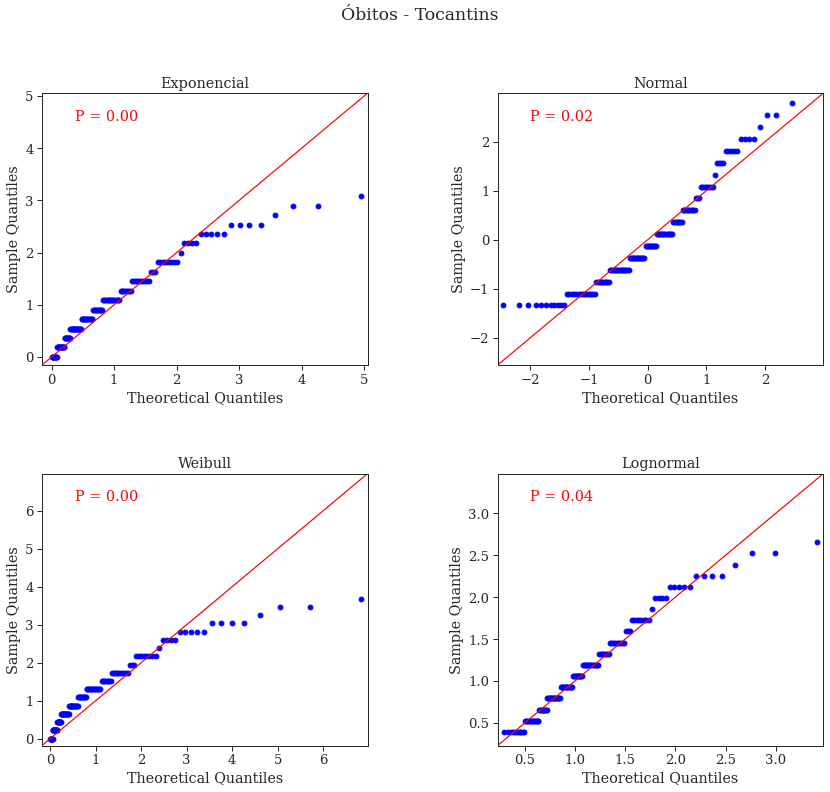

In [12]:
a = final(df_casos['Amapá'], 'Casos - Amapá', 'qqplot')
a = final(df_casos['Tocantins'], 'Casos - Tocantins', 'qqplot')
a = final(df_obito['Amapá'], 'Óbitos - Amapá', 'qqplot')
a = final(df_obito['Tocantins'], 'Óbitos - Tocantins', 'qqplot')